# **Part1: Diffusion Models and Latent Diffusion**



In [32]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # 只使用第3号 GPU

import torch
print("Using GPU:", torch.cuda.get_device_name(0))


Thu Oct 30 22:44:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.169                Driver Version: 570.169        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:21:00.0 Off |                  Off |
| 46%   35C    P8             27W /  450W |     407MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [33]:
import numpy
import pandas
from datasets import load_dataset

print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("datasets:", __import__('datasets').__version__)


numpy: 1.23.5
pandas: 2.2.2
datasets: 4.2.0


## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

共 100000 张生成样本，按类别聚合完成。
开始补充生成样本 (可重复)
用户 0 补充 8157 张生成样本
用户 1 补充 21123 张生成样本
用户 2 补充 18383 张生成样本
用户 3 补充 4581 张生成样本
用户 4 补充 4068 张生成样本
用户 5 补充 8007 张生成样本
用户 6 补充 7156 张生成样本
用户 7 补充 8202 张生成样本
用户 8 补充 11238 张生成样本
用户 9 补充 8375 张生成样本
开始补充生成样本 (可重复)
用户 0 补充 30365 张生成样本
用户 1 补充 11921 张生成样本
用户 2 补充 18327 张生成样本
用户 3 补充 20313 张生成样本
用户 4 补充 16557 张生成样本
用户 5 补充 17998 张生成样本
用户 6 补充 16290 张生成样本
用户 7 补充 15060 张生成样本
用户 8 补充 15859 张生成样本
用户 9 补充 21610 张生成样本


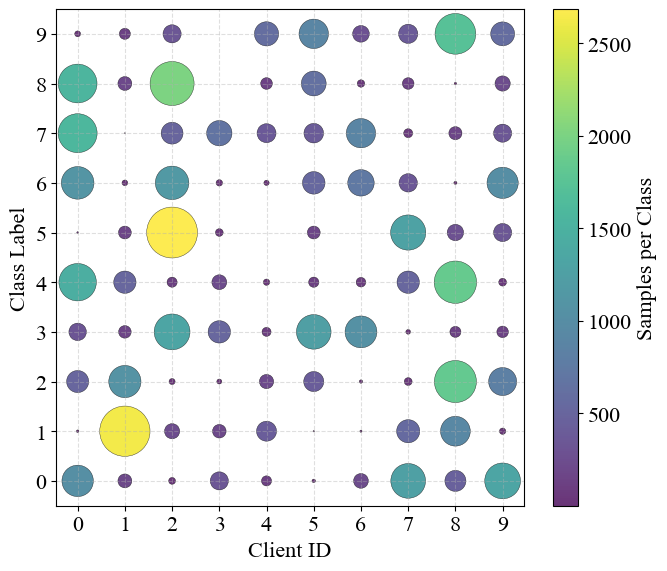

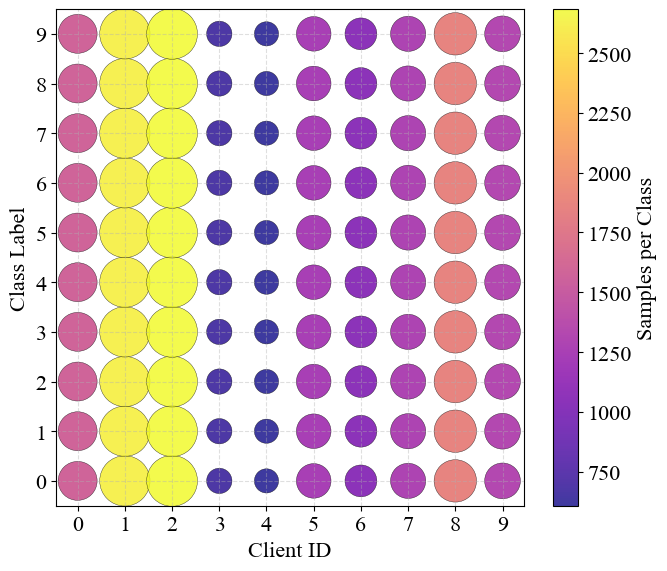

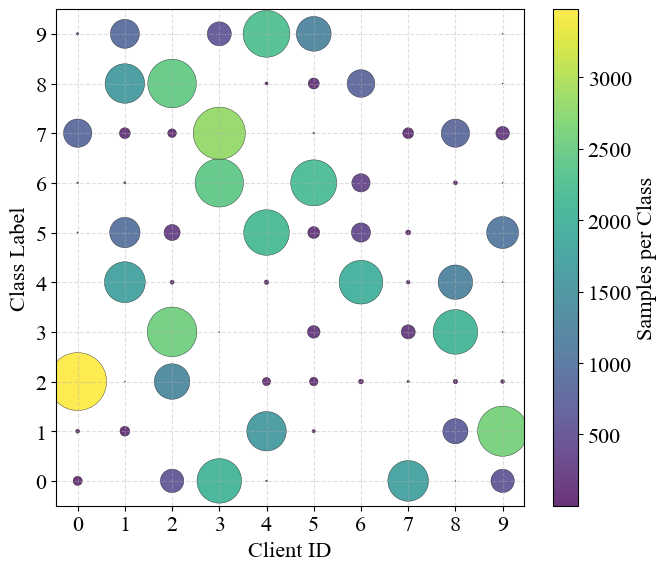

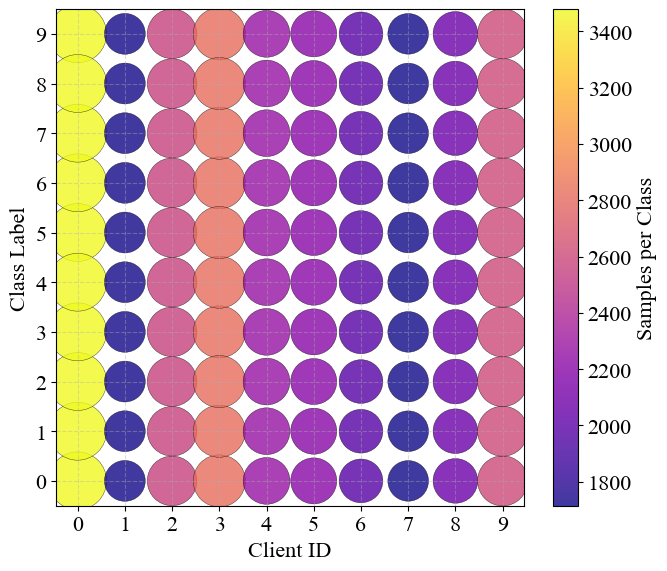

In [ ]:
import os, json, random, copy
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib

# ========== 全局字体大小设置 ==========
matplotlib.rcParams['font.size'] = 16          # 默认字体大小
matplotlib.rcParams['axes.titlesize'] = 18     # 标题字体大小
matplotlib.rcParams['axes.labelsize'] = 16     # x/y 轴标签大小
matplotlib.rcParams['xtick.labelsize'] = 14    # x 轴刻度大小
matplotlib.rcParams['ytick.labelsize'] = 14    # y 轴刻度大小
matplotlib.rcParams['legend.fontsize'] = 14    # 图例字体大小
matplotlib.rcParams['figure.titlesize'] = 18   # figure 标题大小

# ========== 手动注册 Times New Roman 字体 ==========
font_path = "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf"
if os.path.exists(font_path):
    prop = fm.FontProperties(fname=font_path)
else:
    print("⚠️ Times New Roman font file not found, using default font.")
    prop = None

save_dir = "checkpoints_finetune_cifar10"

# ========== 加载生成标签信息 ==========
gen_dir = os.path.join(save_dir, "generated_cifar10")
with open(os.path.join(gen_dir, "generation_labels.json"), "r") as f:
    gen_records = json.load(f)

# ========== 构造生成样本索引表 ==========
gen_by_label = defaultdict(list)
gen_idx_to_label = {}
for idx, rec in enumerate(gen_records):
    neg_idx = -10000 - idx  # 生成负索引
    gen_by_label[rec["label"]].append(neg_idx)
    gen_idx_to_label[neg_idx] = rec["label"]

print(f"共 {len(gen_records)} 张生成样本，按类别聚合完成。")

# ========== 统计每个用户每个类别样本数 ==========
def count_user_label(user_data_idx, dataset):
    records = []
    for uid, idxs in user_data_idx.items():
        labels = []
        for i in idxs:
            if i >= 0:
                labels.append(dataset[i]['label'])
            else:
                labels.append(gen_idx_to_label[i])
        for c, cnt in Counter(labels).items():
            records.append((uid, c, cnt))
    return np.array(records)

counts_origin = count_user_label(user_data_idx, train_dataset)

# ========== 补充函数：按用户均衡类别分布 ==========
def augment_balanced(user_data_idx, gen_by_label, repeatable=True):
    new_user_idx = copy.deepcopy(user_data_idx)
    gen_available = copy.deepcopy(gen_by_label)
    print(f"开始补充生成样本 ({'可重复' if repeatable else '不可重复'})")

    for uid, idxs in new_user_idx.items():
        user_labels = [train_dataset[i]['label'] for i in idxs if i >= 0]
        counter = Counter(user_labels)
        if len(counter) == 0:
            continue
        max_count = max(counter.values())

        for c in range(10):
            current = counter.get(c, 0)
            need = max_count - current
            if need > 0 and c in gen_available and len(gen_available[c]) > 0:
                available_gen = gen_available[c]
                chosen = random.choices(available_gen, k=need) if repeatable else random.sample(
                    available_gen, k=min(need, len(available_gen))
                )
                new_user_idx[uid].extend(chosen)
                if not repeatable:
                    for g in chosen:
                        gen_available[c].remove(g)
        print(f"用户 {uid} 补充 {sum(max_count - counter.get(c,0) for c in range(10))} 张生成样本")
    return new_user_idx

# ========== 不同 alpha 的非IID划分 ==========
alphas = [0.5, 0.1]
user_data_indices = {}
counts_orig = {}
counts_aug = {}

for alpha in alphas:
    user_data_idx_alpha = create_non_iid_splits(train_dataset, num_users, alpha)
    user_data_indices[alpha] = user_data_idx_alpha

    counts_orig[alpha] = count_user_label(user_data_idx_alpha, train_dataset)
    user_data_idx_aug = augment_balanced(user_data_idx_alpha, gen_by_label, repeatable=True)
    counts_aug[alpha] = count_user_label(user_data_idx_aug, train_dataset)

# ========== 绘图函数 ==========
def plot_client_distribution(counts, title, cmap):
    client_ids = counts[:, 0].astype(float)
    class_ids = counts[:, 1].astype(float)
    sample_counts = counts[:, 2].astype(float)

    plt.figure(figsize=(7, 6))
    sc = plt.scatter(
        client_ids, class_ids,
        c=sample_counts, cmap=cmap,
        s=sample_counts * 0.5, alpha=0.8,
        edgecolors='k', linewidths=0.3
    )
    cbar = plt.colorbar(sc)  # 创建颜色条
    cbar.set_label('Samples per Class', fontproperties=prop)  # 设置 label 字体
    for tick in cbar.ax.get_yticklabels():  # 设置刻度字体
        tick.set_fontproperties(prop)

    plt.xlabel("Client ID", fontproperties=prop)
    plt.ylabel("Class Label",  fontproperties=prop)
    plt.xticks(np.arange(0, len(np.unique(client_ids)), 1), fontproperties=prop)
    plt.yticks(np.arange(0, 10, 1), fontproperties=prop)
    plt.ylim(-0.5, 9.5)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# # ========== 绘制结果 ==========
# for alpha in alphas:
alpha = 0.5
plot_client_distribution(counts_orig[alpha],
                            f'Non-IID Distribution ($\\alpha={alpha}$)',
                            cmap='viridis')

plot_client_distribution(counts_aug[alpha],
                            f'Non-IID Distribution ($\\alpha={alpha}$) After Augmentation',
                            cmap='plasma')
